## CS 445: Computational Photography

## Programming Project #3: Gradient Domain Fusion

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from random import random
import time
import scipy
import scipy.sparse.linalg

# modify to where you store your project data including utils.py
datadir = "/content/drive/My Drive/CS180/"

utilfn = datadir + "utils.py"
!cp "$utilfn" .
samplesfn = datadir + "samples"
!cp -r "$samplesfn" .
import utils

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

## Part 1 Toy Problem (20 pts)

In [ ]:
def toy_reconstruct(im):
    """
    The implementation for gradient domain processing is not complicated, but it is easy to make a mistake, so let's start with a toy example. Reconstruct this image from its gradient values, plus one pixel intensity. Denote the intensity of the source image at (x, y) as s(x,y) and the value to solve for as v(x,y). For each pixel, then, we have two objectives:
    1. minimize (v(x+1,y)-v(x,y) - (s(x+1,y)-s(x,y)))^2
    2. minimize (v(x,y+1)-v(x,y) - (s(x,y+1)-s(x,y)))^2
    Note that these could be solved while adding any constant value to v, so we will add one more objective:
    3. minimize (v(1,1)-s(1,1))^2

    :param toy_img: numpy.ndarray
    """

    im_h, im_w = im.shape
    im2var = np.arange(im_h * im_w).reshape(im_h, im_w)

    A = np.zeros((2 * im_h * im_w, im_h*im_w))
    b = np.zeros((2 * im_h * im_w,))
    e = 0

    #Then, you can write objective 1 above as:
    for y in np.arange(0, im_h):
      for x in np.arange(0, im_w):
        if (x == 0 and y == 0):
          A[0][im2var[0][0]] = 1
          b[0] = im[0][0]
        if x < im_w - 1:
          A[e][im2var[y][x+1]] = 1
          A[e][im2var[y][x]] = -1
          b[e] = im[y][x+1] - im[y][x]
          e += 1
        if y < im_h - 1:
          A[e][im2var[y+1][x]] = 1
          A[e][im2var[y][x]] = -1
          b[e] = im[y+1][x] - im[y][x]
          e += 1

    A = scipy.sparse.csr_matrix(A)
    #To solve for v, use v = scipy.sparse.linalg.lsqr(A, b); Then, copy each solved value to the appropriate pixel in the output image.
    v = scipy.sparse.linalg.lsqr(A, b)

    return v[0].reshape((im_h, im_w))

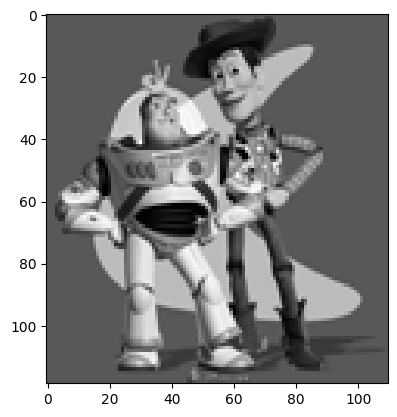

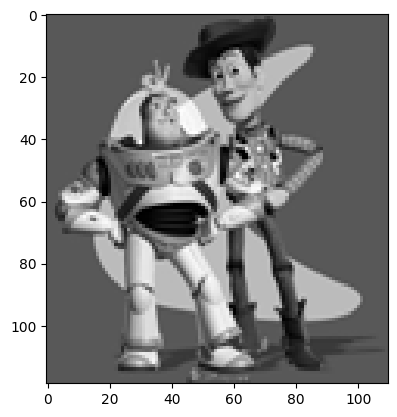

Max error is:  0.4267848711277742


In [ ]:
toy_img = cv2.cvtColor(cv2.imread('samples/toy_problem.png'), cv2.COLOR_BGR2GRAY).astype('double') / 255.0
plt.imshow(toy_img, cmap="gray")
plt.show()

im_out = toy_reconstruct(toy_img)
plt.imshow(im_out, cmap="gray")
plt.show()
print("Max error is: ", np.sqrt(((im_out - toy_img)**2).max()))

## Preparation

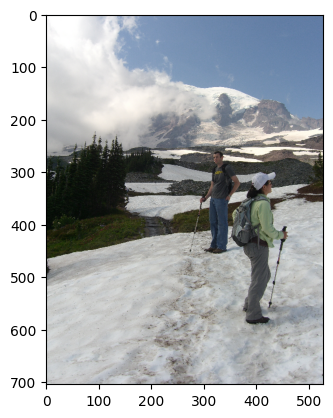

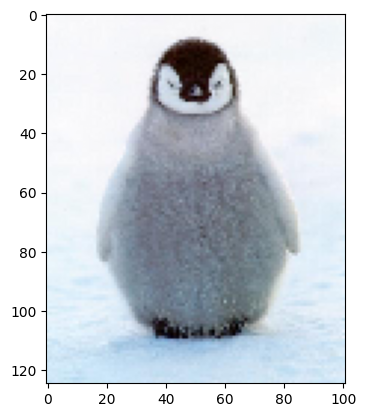

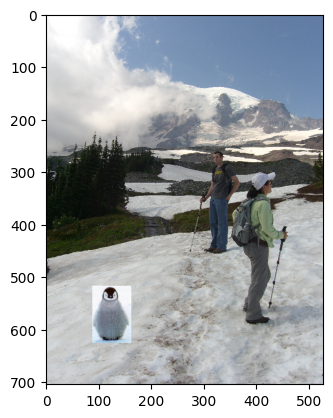

In [ ]:
background_img = cv2.cvtColor(cv2.imread('samples/im2.JPG'), cv2.COLOR_BGR2RGB).astype('double') / 255.0
background_img = cv2.resize(background_img, (background_img.shape[1]//4, background_img.shape[0]//4), interpolation=cv2.INTER_CUBIC)
plt.figure()
plt.imshow(background_img)
plt.show()
object_img = cv2.cvtColor(cv2.imread('samples/penguin-chick.jpeg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0
object_img = cv2.resize(object_img, (object_img.shape[1]//4, object_img.shape[0]//4), interpolation=cv2.INTER_CUBIC)
plt.imshow(object_img)
plt.show()

use_interface = False  # set to true if you want to use the interface to choose points (might not work in Colab)
if not use_interface:
  xs = np.array((65, 359, 359, 65))//4
  ys = np.array((24, 24, 457, 457))//4
  object_mask = utils.get_mask(ys, xs, object_img)
  bottom_center = np.array((500, 2500))//4 # (x,y)

  object_img, object_mask = utils.crop_object_img(object_img, object_mask)
  bg_ul = utils.upper_left_background_rc(object_mask, bottom_center)
  plt.imshow(utils.get_combined_img(background_img, object_img, object_mask, bg_ul))

In [ ]:
if use_interface:
  import matplotlib.pyplot as plt
  %matplotlib notebook
  mask_coords = specify_mask(object_img)

In [ ]:
if use_interface:
  xs = mask_coords[0]
  ys = mask_coords[1]
  %matplotlib inline
  import matplotlib.pyplot as plt
  plt.figure()
  object_mask = get_mask(ys, xs, object_img)

In [ ]:
if use_interface:
  %matplotlib notebook
  import matplotlib.pyplot as plt
  bottom_center = specify_bottom_center(background_img)
  %matplotlib inline
  import matplotlib.pyplot as plt

  object_img, object_mask = utils.crop_object_img(object_img, object_mask)
  bg_ul = utils.upper_left_background_rc(object_mask, bottom_center)
  plt.imshow(utils.get_combined_img(background_img, object_img, object_mask, bg_ul))



## Part 2 Poisson Blending (50 pts)

In [ ]:
def get_combined_img(bg_img, object_img, object_mask, bg_ul):
    combined_img = bg_img.copy()
    (nr, nc) = object_img.shape[:2]

    for b in np.arange(object_img.shape[2]):
      combined_patch = combined_img[bg_ul[0]:bg_ul[0]+nr, bg_ul[1]:bg_ul[1]+nc, b]
      combined_patch = combined_patch*(1-object_mask) + object_img[:,:,b]*object_mask
      combined_img[bg_ul[0]:bg_ul[0]+nr, bg_ul[1]:bg_ul[1]+nc, b] =  combined_patch

    return combined_img

In [ ]:
def poisson_blend(object_img, object_mask, bg_img, bg_ul):
    """
    Returns a Poisson blended image with masked object_img over the bg_img at position specified by bg_ul.
    Can be implemented to operate on a single channel or multiple channels
    :param object_img: the image containing the foreground object
    :param object_mask: the mask of the foreground object in object_img
    :param background_img: the background image
    :param bg_ul: position (row, col) in background image corresponding to (0,0) of object_img
    """
    source = object_img

    im_h, im_w = source.shape
    im2var = np.arange(im_h * im_w).reshape(im_h, im_w)

    A = np.zeros((4*im_h * im_w, im_h*im_w))
    b = np.zeros((4*im_h * im_w,))
    e = 0

    #Then, you can write objective 1 above as:
    for y in np.arange(0, im_h):
      for x in np.arange(0, im_w):
          for dy, dx in ([0, 1], [1, 0]):
            if (0 <= y + dy < im_h) and (0 <= x + dx < im_w):
              A[e][im2var[y][x]] = 1
              A[e][im2var[y+dy][x+dx]] = -1
              b[e] = source[y][x] - source[y+dy][x+dx]
              e += 1
            else:
              A[e][im2var[y][x]] = 1
              b[e] = bg_img[bg_ul[0]+y+dy][bg_ul[1]+x+dx]
              e += 1

            if (0 <= y - dy < im_h) and (0 <= x - dx < im_w):
              A[e][im2var[y][x]] = 1
              A[e][im2var[y-dy][x-dx]] = -1
              b[e] = source[y][x] - source[y-dy][x-dx]
              e += 1
            else:
              A[e][im2var[y][x]] = 1
              b[e] = bg_img[bg_ul[0]+y-dy][bg_ul[1]+x-dx]
              e += 1

    A = scipy.sparse.csr_matrix(A)
    #To solve for v, use v = scipy.sparse.linalg.lsqr(A, b); Then, copy each solved value to the appropriate pixel in the output image.
    v = scipy.sparse.linalg.lsqr(A, b)
    v = v[0].reshape((im_h, im_w))

    return get_combined_img(bg_img[:,:,None], v[:,:,None], object_mask, bg_ul).squeeze()

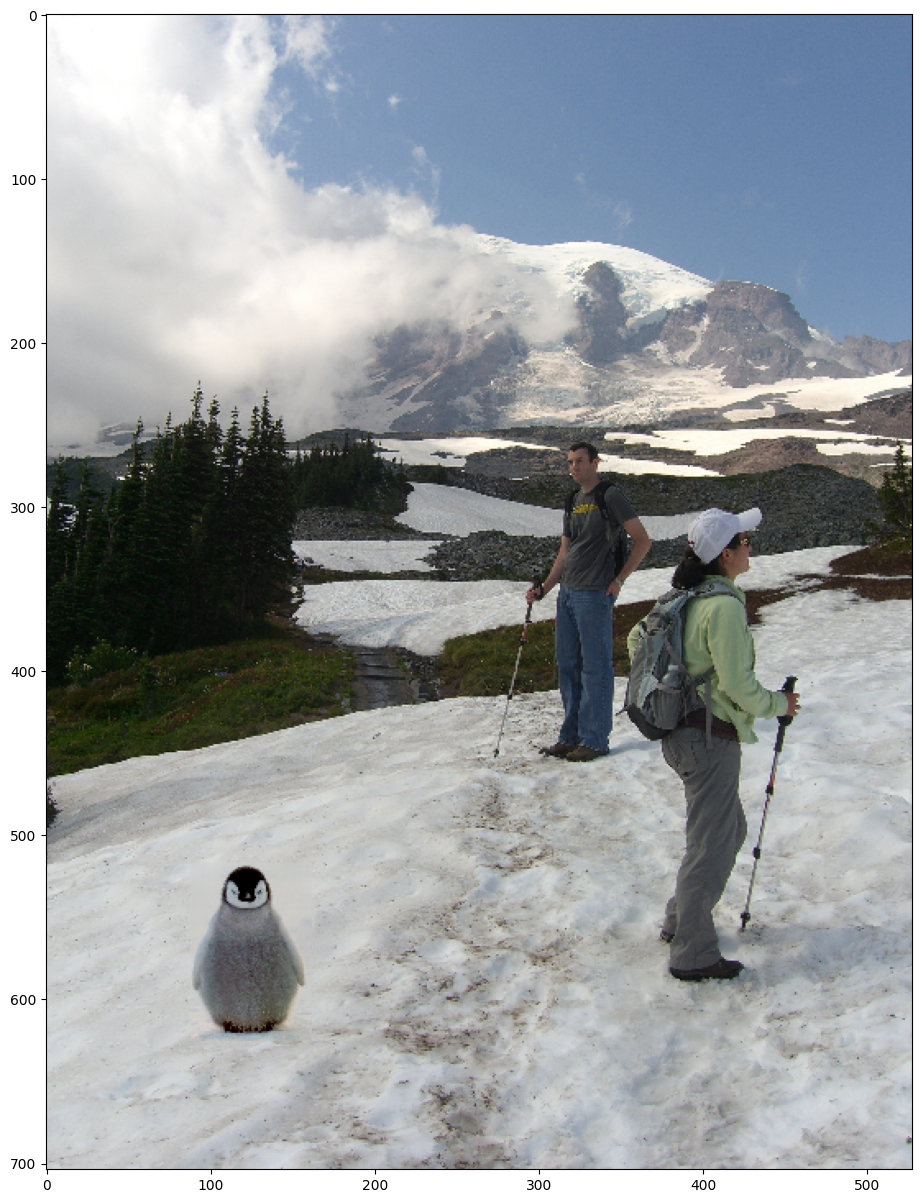

In [ ]:
im_blend = np.zeros(background_img.shape)
for b in np.arange(3):
  im_blend[:,:,b] = poisson_blend(object_img[:,:,b], object_mask, background_img[:,:,b].copy(), bg_ul)

plt.figure(figsize=(15,15))
plt.imshow(im_blend)

# Bells & Whistles (Extra Points)

## Part 3 Mixed Gradients (20 pts)

In [152]:
def mixed_blend(object_img, object_mask, bg_img, bg_ul):
    """
    Returns a mixed gradient blended image with masked object_img over the bg_img at position specified by bg_ul.
    Can be implemented to operate on a single channel or multiple channels
    :param object_img: the image containing the foreground object
    :param object_mask: the mask of the foreground object in object_img
    :param background_img: the background image
    :param bg_ul: position (row, col) in background image corresponding to (0,0) of object_img
    """
    source = object_img

    im_h, im_w = source.shape
    im2var = np.arange(im_h * im_w).reshape(im_h, im_w)

    A = np.zeros((4*im_h * im_w, im_h*im_w))
    b = np.zeros((4*im_h * im_w,))
    e = 0

    #Then, you can write objective 1 above as:
    for y in np.arange(0, im_h):
      for x in np.arange(0, im_w):
          for dy, dx in ([0, 1], [1, 0]):
            bg_y, bg_x = bg_ul[0] + y, bg_ul[1] + x
            if (0 <= y + dy < im_h) and (0 <= x + dx < im_w):
              A[e][im2var[y][x]] = 1
              A[e][im2var[y+dy][x+dx]] = -1
              b[e] = source[y][x] - source[y+dy][x+dx] if abs(source[y][x] - source[y+dy][x+dx]) > abs(bg_img[bg_y][bg_x] - bg_img[bg_y+dy][bg_x+dx]) else bg_img[bg_y][bg_x] - bg_img[bg_y+dy][bg_x+dx]
              e += 1
            else:
              A[e][im2var[y][x]] = 1
              b[e] = bg_img[bg_y][bg_x]
              e += 1

            if (0 <= y - dy < im_h) and (0 <= x - dx < im_w):
              A[e][im2var[y][x]] = 1
              A[e][im2var[y-dy][x-dx]] = -1
              b[e] = source[y][x] - source[y-dy][x-dx] if abs(source[y][x] - source[y-dy][x-dx]) > abs(bg_img[bg_y][bg_x] - bg_img[bg_y-dy][bg_x-dx]) else bg_img[bg_y][bg_x] - bg_img[bg_y-dy][bg_x-dx]
              e += 1
            else:
              A[e][im2var[y][x]] = 1
              b[e] = bg_img[bg_y][bg_x]
              e += 1

    A = scipy.sparse.csr_matrix(A)
    #To solve for v, use v = scipy.sparse.linalg.lsqr(A, b); Then, copy each solved value to the appropriate pixel in the output image.
    v = scipy.sparse.linalg.lsqr(A, b)
    v = v[0].reshape((im_h, im_w))

    return get_combined_img(bg_img[:,:,None], v[:,:,None], object_mask, bg_ul).squeeze()

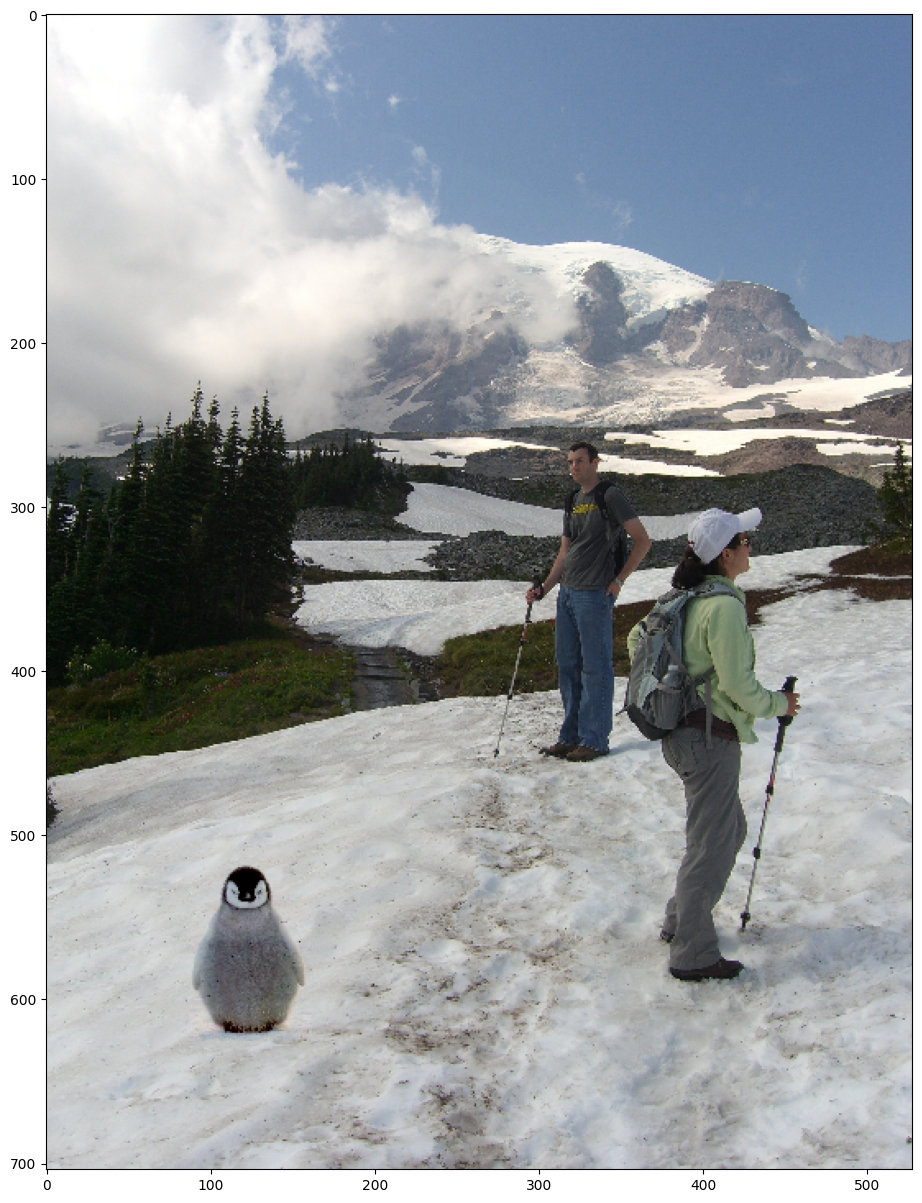

In [ ]:
im_mix = np.zeros(background_img.shape)
for b in np.arange(3):
  im_mix[:,:,b] = mixed_blend(object_img[:,:,b], object_mask, background_img[:,:,b].copy(), bg_ul)

plt.figure(figsize=(15,15))
plt.imshow(im_mix)

## Color2Gray (20 pts)

In [177]:
def color2gray(im):
    im_h, im_w, _ = im.shape
    im2var = np.arange(im_h * im_w).reshape(im_h, im_w)

    im_mix = np.zeros(im.shape)

    gray = cv2.cvtColor((im * 255).astype('uint8'), cv2.COLOR_RGB2GRAY).astype('double') / 255.0

    for c in np.arange(3):
      channel = im[:,:,c]
      A = np.zeros((4 * im_h * im_w, im_h*im_w))
      b = np.zeros((4 * im_h * im_w,))
      e = 0

      #Then, you can write objective 1 above as:
      for y in np.arange(0, im_h):
        for x in np.arange(0, im_w):
            for dy, dx in ([0, 1], [1, 0]):
              if (0 <= y + dy < im_h) and (0 <= x + dx < im_w):
                A[e][im2var[y][x]] = 1
                A[e][im2var[y+dy][x+dx]] = -1
                b[e] = channel[y][x] - channel[y+dy][x+dx] if abs(channel[y][x] - channel[y+dy][x+dx]) > abs(gray[y][x] - gray[y+dy][x+dx]) else gray[y][x] - gray[y+dy][x+dx]
                e += 1

              if (0 <= y - dy < im_h) and (0 <= x - dx < im_w):
                A[e][im2var[y][x]] = 1
                A[e][im2var[y-dy][x-dx]] = -1
                b[e] = channel[y][x] - channel[y-dy][x-dx] if abs(channel[y][x] - channel[y-dy][x-dx]) > abs(gray[y][x] - gray[y-dy][x-dx]) else gray[y][x] - gray[y-dy][x-dx]
                e += 1

      A = scipy.sparse.csr_matrix(A)
      #To solve for v, use v = scipy.sparse.linalg.lsqr(A, b); Then, copy each solved value to the appropriate pixel in the output image.
      v = scipy.sparse.linalg.lsqr(A, b)

      im_mix[:,:,c] = v[0].reshape((im_h, im_w))

    return np.max(im_mix, axis=-1)

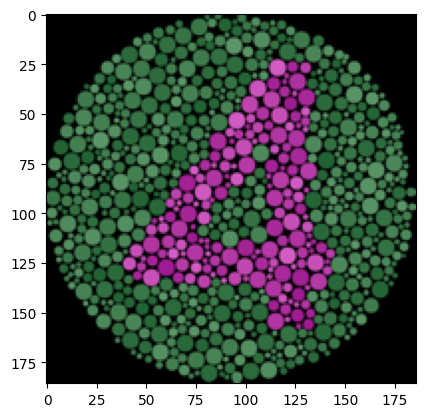

In [180]:
colorBlind4 = cv2.cvtColor(cv2.imread('samples/colorBlind4.png'), cv2.COLOR_BGR2RGB).astype('double') / 255.0
colorBlind4 = cv2.resize(colorBlind4, (colorBlind4.shape[1], colorBlind4.shape[0]), interpolation=cv2.INTER_CUBIC)
plt.figure()
plt.imshow(colorBlind4)
plt.show()

In [181]:
gray_colorBlind4 = color2gray(colorBlind4)

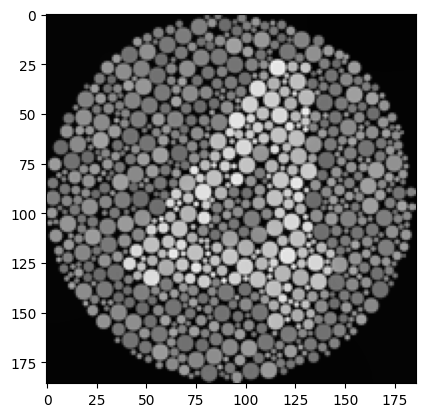

In [182]:
plt.imshow(gray_colorBlind4, cmap='gray')

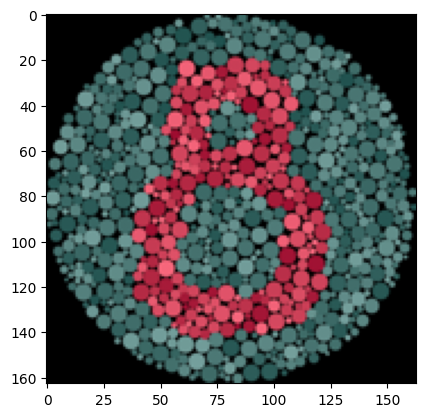

In [186]:
colorBlind8 = cv2.cvtColor(cv2.imread('samples/colorBlind8.png'), cv2.COLOR_BGR2RGB).astype('double') / 255.0
colorBlind8 = cv2.resize(colorBlind8, (colorBlind8.shape[1], colorBlind8.shape[0]), interpolation=cv2.INTER_CUBIC)
plt.figure()
plt.imshow(colorBlind8)
plt.show()

In [187]:
gray_colorBlind8 = color2gray(colorBlind8)

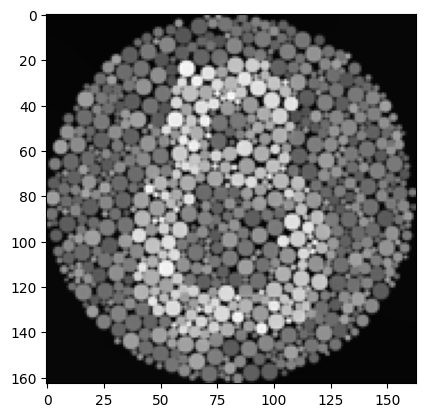

In [188]:
plt.imshow(gray_colorBlind8, cmap='gray')